In [1]:
!pip install catboost
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv(r'drive/MyDrive/Skripsi/india.csv')

In [4]:
#Dropping unnecessary columns
cols_to_drop = ['Station_Code', 'Locations', 'State', 'Temp', 'Year']
df = df.drop(cols_to_drop, axis=1)
df.head()

,DO,pH,EC,BOD,Nitrate,FecalC,TotalC,Class
0,6.7,7.5,203.0,6.940049,0.1,11.0,27.0,4
1,5.7,7.2,189.0,2.000000,0.2,4953.0,8391.0,4
2,6.3,6.9,179.0,1.700000,0.1,3243.0,5330.0,4
3,5.8,6.9,64.0,3.800000,0.5,5382.0,8443.0,4
4,5.8,7.3,83.0,1.900000,0.4,3428.0,5500.0,4


In [5]:
#Seperating X & y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [6]:
#Splitting test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [7]:
#Applying data standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
#Empty result dataframe
res = pd.DataFrame(index=['precision','recall','f1-score','accuracy'])

In [9]:
#Result Function
def result(clf, Classifier_Name, X_train, X_test):
  #Model Fitting
  clf.fit(X_train, y_train)
  
  #Showing performance result
  y_pred=clf.predict(X_test)
  from sklearn.metrics import classification_report
  clf_res = classification_report(y_test, y_pred, output_dict=True)

  #Append classifier result to result DataFrame
  res[str(Classifier_Name)] = [clf_res['weighted avg']['precision'],
                               clf_res['weighted avg']['recall'], 
                               clf_res['weighted avg']['f1-score'], 
                               clf_res['accuracy']]
  display(res)

  #Creating confusion matrix illustration
  from sklearn.metrics import ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, xticks_rotation="vertical", 
    display_labels=['Unsuitable', 'Very Poor', 'Poor', 'Good', 'Excellent'])
  disp.ax_.set_title("Confusion Matrix for " + str(Classifier_Name) + " Classifier")

,Decision Tree
precision,0.993896
recall,0.993311
f1-score,0.993213
accuracy,0.993311


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
7,"(0, 1, 2, 3, 4, 5, 6)","[0.992831541218638, 0.989247311827957, 0.99283...",0.990666,"(0, 1, 2, 3, 4, 5, 6)",0.006274,0.004882,0.002441
6,"(1, 2, 3, 4, 5, 6)","[0.996415770609319, 0.992831541218638, 0.99283...",0.993538,"(1, 2, 3, 4, 5, 6)",0.00346,0.002692,0.001346
5,"(1, 3, 4, 5, 6)","[0.989247311827957, 0.996415770609319, 0.99641...",0.994257,"(1, 3, 4, 5, 6)",0.003686,0.002868,0.001434
4,"(1, 3, 5, 6)","[0.989247311827957, 0.992831541218638, 0.99641...",0.992821,"(1, 3, 5, 6)",0.004128,0.003212,0.001606
3,"(1, 3, 5)","[0.985663082437276, 0.996415770609319, 0.99283...",0.992824,"(1, 3, 5)",0.005043,0.003924,0.001962
2,"(1, 5)","[0.982078853046595, 0.989247311827957, 0.99283...",0.986357,"(1, 5)",0.006795,0.005287,0.002643
1,"(5,)","[0.96415770609319, 0.942652329749104, 0.964157...",0.955489,"(5,)",0.01077,0.00838,0.00419


('1', '3', '4', '5', '6')

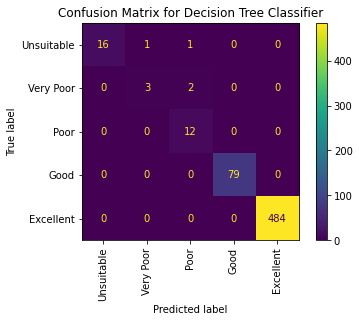

In [10]:
#Using Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
#Wrapper Feature Selection
#from sklearn.feature_selection import SequentialFeatureSelector
#sfs_dt = SequentialFeatureSelector(dt_clf, direction='backward')
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector
sfs_dt = SequentialFeatureSelector(dt_clf, forward=False, k_features="best")
sfs_dt.fit(X_train, y_train)
X_train_dt = sfs_dt.transform(X_train)
X_test_dt = sfs_dt.transform(X_test)

#Display Result
result(dt_clf, "Decision Tree", X_train_dt, X_test_dt)

#Creating selected features dataframe with corresponding column names
display(pd.DataFrame.from_dict(sfs_dt.get_metric_dict()).T)
display(sfs_dt.k_feature_names_)

,Decision Tree,Random Forest
precision,0.993896,0.983244
recall,0.993311,0.981605
f1-score,0.993213,0.982351
accuracy,0.993311,0.981605


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
7,"(0, 1, 2, 3, 4, 5, 6)","[0.978494623655914, 0.985663082437276, 0.97491...",0.977742,"(0, 1, 2, 3, 4, 5, 6)",0.005404,0.004205,0.002102
6,"(0, 1, 2, 3, 5, 6)","[0.989247311827957, 0.985663082437276, 0.98924...",0.986357,"(0, 1, 2, 3, 5, 6)",0.003478,0.002706,0.001353
5,"(0, 1, 3, 5, 6)","[0.985663082437276, 0.989247311827957, 0.98924...",0.987796,"(0, 1, 3, 5, 6)",0.002265,0.001762,0.000881
4,"(0, 1, 3, 5)","[0.978494623655914, 0.992831541218638, 0.98924...",0.987079,"(0, 1, 3, 5)",0.006249,0.004862,0.002431
3,"(1, 3, 5)","[0.974910394265233, 0.985663082437276, 0.98207...",0.982775,"(1, 3, 5)",0.006101,0.004747,0.002373
2,"(1, 5)","[0.985663082437276, 0.989247311827957, 0.98566...",0.98564,"(1, 5)",0.007742,0.006024,0.003012
1,"(5,)","[0.96415770609319, 0.946236559139785, 0.964157...",0.956205,"(5,)",0.009434,0.00734,0.00367


('0', '1', '3', '5', '6')

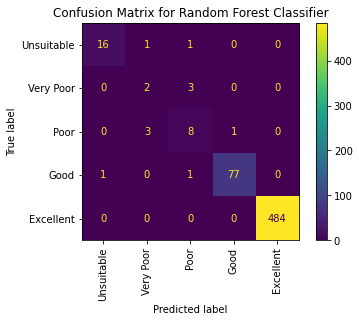

In [11]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

#Wrapper Feature Selection
sfs_rf = SequentialFeatureSelector(rf_clf, forward=False, k_features="best")
sfs_rf.fit(X_train, y_train)
X_train_rf = sfs_rf.transform(X_train)
X_test_rf = sfs_rf.transform(X_test)

#Display Result
result(rf_clf, "Random Forest", X_train_rf, X_test_rf)

display(pd.DataFrame.from_dict(sfs_rf.get_metric_dict()).T)
display(sfs_rf.k_feature_names_)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Decision Tree,Random Forest,SVM
precision,0.993896,0.983244,0.807230
recall,0.993311,0.981605,0.837793
f1-score,0.993213,0.982351,0.784964
accuracy,0.993311,0.981605,0.837793


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
7,"(0, 1, 2, 3, 4, 5, 6)","[0.8351254480286738, 0.8387096774193549, 0.838...",0.83848,"(0, 1, 2, 3, 4, 5, 6)",0.002697,0.002099,0.001049
6,"(0, 1, 3, 4, 5, 6)","[0.8387096774193549, 0.8387096774193549, 0.849...",0.842786,"(0, 1, 3, 4, 5, 6)",0.005311,0.004132,0.002066
5,"(0, 1, 3, 4, 6)","[0.8422939068100358, 0.8387096774193549, 0.853...",0.84422,"(0, 1, 3, 4, 6)",0.006281,0.004887,0.002444
4,"(0, 1, 3, 4)","[0.8351254480286738, 0.8351254480286738, 0.845...",0.839916,"(0, 1, 3, 4)",0.007955,0.006189,0.003094
3,"(0, 1, 3)","[0.8351254480286738, 0.8315412186379928, 0.838...",0.838485,"(0, 1, 3)",0.006213,0.004834,0.002417
2,"(0, 3)","[0.8387096774193549, 0.8279569892473119, 0.835...",0.837049,"(0, 3)",0.008838,0.006876,0.003438
1,"(0,)","[0.8422939068100358, 0.8279569892473119, 0.820...",0.83274,"(0,)",0.012119,0.009429,0.004714


('0', '1', '3', '4', '6')

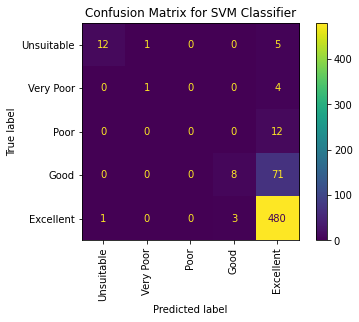

In [12]:
# Using Kernel SVM Classifier
from sklearn.svm import SVC
svm_clf = SVC(kernel = 'rbf', random_state = 0)

#Wrapper Feature Selection
sfs_svm = SequentialFeatureSelector(svm_clf, forward=False, k_features="best")
sfs_svm.fit(X_train, y_train)
X_train_svm = sfs_svm.transform(X_train)
X_test_svm = sfs_svm.transform(X_test)

result(svm_clf, "SVM", X_train_svm, X_test_svm)

display(pd.DataFrame.from_dict(sfs_svm.get_metric_dict()).T)
display(sfs_svm.k_feature_names_)

,Decision Tree,Random Forest,SVM,Naive Bayes
precision,0.993896,0.983244,0.807230,0.957199
recall,0.993311,0.981605,0.837793,0.946488
f1-score,0.993213,0.982351,0.784964,0.950290
accuracy,0.993311,0.981605,0.837793,0.946488


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
7,"(0, 1, 2, 3, 4, 5, 6)","[0.9354838709677419, 0.9390681003584229, 0.935...",0.936827,"(0, 1, 2, 3, 4, 5, 6)",0.013267,0.010323,0.005161
6,"(0, 1, 3, 4, 5, 6)","[0.9498207885304659, 0.953405017921147, 0.9498...",0.947588,"(0, 1, 3, 4, 5, 6)",0.01299,0.010107,0.005053
5,"(0, 1, 3, 5, 6)","[0.9498207885304659, 0.9498207885304659, 0.956...",0.949743,"(0, 1, 3, 5, 6)",0.007784,0.006057,0.003028
4,"(0, 1, 3, 5)","[0.9498207885304659, 0.956989247311828, 0.9605...",0.951894,"(0, 1, 3, 5)",0.011596,0.009022,0.004511
3,"(0, 1, 5)","[0.956989247311828, 0.953405017921147, 0.96415...",0.954767,"(0, 1, 5)",0.006982,0.005432,0.002716
2,"(1, 5)","[0.9605734767025089, 0.956989247311828, 0.9641...",0.9562,"(1, 5)",0.007475,0.005816,0.002908
1,"(5,)","[0.9498207885304659, 0.9390681003584229, 0.960...",0.946871,"(5,)",0.011496,0.008944,0.004472


('1', '5')

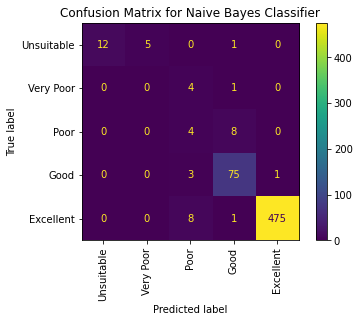

In [13]:
# Using Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()

#Wrapper Feature Selection
sfs_nb = SequentialFeatureSelector(nb_clf, forward=False, k_features="best")
sfs_nb.fit(X_train, y_train)
X_train_nb = sfs_nb.transform(X_train)
X_test_nb = sfs_nb.transform(X_test)

result(nb_clf, "Naive Bayes", X_train_nb, X_test_nb)

display(pd.DataFrame.from_dict(sfs_nb.get_metric_dict()).T)
display(sfs_nb.k_feature_names_)

,Decision Tree,Random Forest,SVM,Naive Bayes,CatBoost
precision,0.993896,0.983244,0.807230,0.957199,0.988340
recall,0.993311,0.981605,0.837793,0.946488,0.986622
f1-score,0.993213,0.982351,0.784964,0.950290,0.985035
accuracy,0.993311,0.981605,0.837793,0.946488,0.986622


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
7,"(0, 1, 2, 3, 4, 5, 6)","[0.9354838709677419, 0.9390681003584229, 0.935...",0.936827,"(0, 1, 2, 3, 4, 5, 6)",0.013267,0.010323,0.005161
6,"(0, 1, 3, 4, 5, 6)","[0.9498207885304659, 0.953405017921147, 0.9498...",0.947588,"(0, 1, 3, 4, 5, 6)",0.01299,0.010107,0.005053
5,"(0, 1, 3, 5, 6)","[0.9498207885304659, 0.9498207885304659, 0.956...",0.949743,"(0, 1, 3, 5, 6)",0.007784,0.006057,0.003028
4,"(0, 1, 3, 5)","[0.9498207885304659, 0.956989247311828, 0.9605...",0.951894,"(0, 1, 3, 5)",0.011596,0.009022,0.004511
3,"(0, 1, 5)","[0.956989247311828, 0.953405017921147, 0.96415...",0.954767,"(0, 1, 5)",0.006982,0.005432,0.002716
2,"(1, 5)","[0.9605734767025089, 0.956989247311828, 0.9641...",0.9562,"(1, 5)",0.007475,0.005816,0.002908
1,"(5,)","[0.9498207885304659, 0.9390681003584229, 0.960...",0.946871,"(5,)",0.011496,0.008944,0.004472


('1', '5')

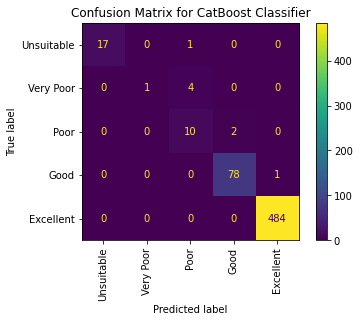

In [14]:
# Using CatBoost Classifier
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(random_seed=42, logging_level='Silent')

#Wrapper Feature Selection
sfs_cb = SequentialFeatureSelector(cb_clf, forward=False, k_features="best")
sfs_cb.fit(X_train, y_train)
X_train_cb = sfs_cb.transform(X_train)
X_test_cb = sfs_cb.transform(X_test)

result(cb_clf, "CatBoost", X_train_cb, X_test_cb)

display(pd.DataFrame.from_dict(sfs_nb.get_metric_dict()).T)
display(sfs_nb.k_feature_names_)